<a href="https://www.kaggle.com/code/lalit7881/tweet-emotions-understanding-feelings-behind-90?scriptVersionId=292738871" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('Agg')  # Setting the Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt is imported

# Ensuring inline plotting in Jupyter Notebook
%matplotlib inline

# Additional libraries for text processing and model building
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

# For reproducibility
np.random.seed(42)

print('Imports and configurations completed.')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Imports and configurations completed.
/kaggle/input/tweet-emotion-recognition/val.csv
/kaggle/input/tweet-emotion-recognition/train.csv
/kaggle/input/tweet-emotion-recognition/test.csv


## Title: Tweet Emotions: Understanding Feelings Behind Tweets

## Description:
Tweet Emotions focuses on analyzing emotions expressed in tweets using Natural Language Processing (NLP). Tweets often carry strong feelings—such as joy, anger, sadness, fear, or surprise—packed into short, informal text with hashtags, emojis, and slang. This project aims to automatically detect and classify these emotions to better understand public opinion and emotional trends on social media.

The process typically involves cleaning tweet text, handling emojis and abbreviations, extracting meaningful features, and applying machine learning or deep learning models (like LSTM, BERT, or other transformer-based models). By accurately identifying emotions, Tweet Emotions can be useful for brand sentiment analysis, mental health monitoring, event impact analysis, and understanding audience reactions in real time.

Overall, Tweet Emotions turns raw social media data into actionable emotional insights, helping organizations and researchers make data-driven decisions based on how people truly feel online.

## Import dataset

In [2]:
train_df = pd.read_csv('/kaggle/input/tweet-emotion-recognition/train.csv', encoding='ascii', delimiter=',')
val_df = pd.read_csv('/kaggle/input/tweet-emotion-recognition/val.csv', encoding='ascii', delimiter=',')
test_df = pd.read_csv('/kaggle/input/tweet-emotion-recognition/test.csv', encoding='ascii', delimiter=',')

# Display dataset information
print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)

Training data shape: (16000, 2)
Validation data shape: (2000, 2)
Test data shape: (2000, 2)


In [3]:
print('Missing values in training set:')
print(train_df.isnull().sum())

# We assume that missing text or label would be troublesome, so drop any such rows
train_df.dropna(subset=['text', 'label'], inplace=True)
val_df.dropna(subset=['text', 'label'], inplace=True)
test_df.dropna(subset=['text', 'label'], inplace=True)

# Confirm that there are no missing values
print('\nAfter cleaning, missing values in training set:')
print(train_df.isnull().sum())


Missing values in training set:
text     0
label    0
dtype: int64

After cleaning, missing values in training set:
text     0
label    0
dtype: int64


In [4]:
train_df.columns

Index(['text', 'label'], dtype='object')

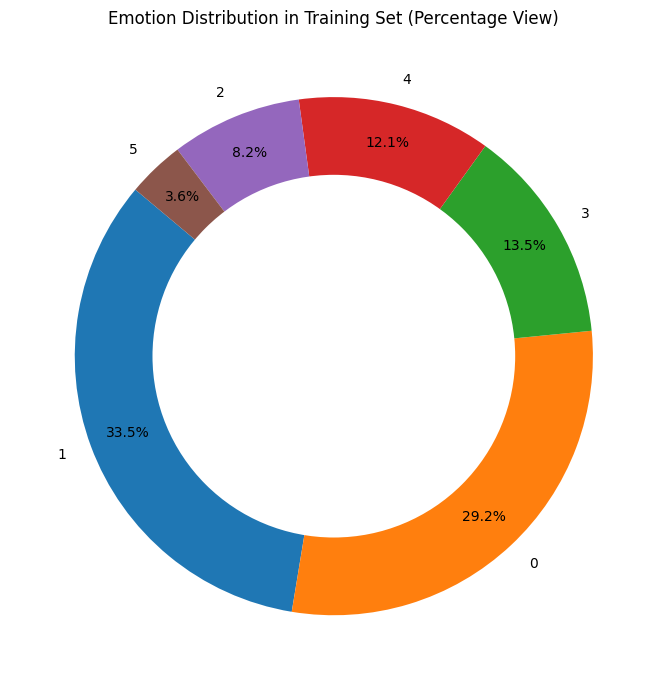

In [5]:
label_counts = train_df['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values

plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    pctdistance=0.85
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

plt.title('Emotion Distribution in Training Set (Percentage View)')
plt.tight_layout()
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),        # unigrams + bigrams
    max_df=0.9,                # ignore very common words
    min_df=3,                  # ignore rare noise
    sublinear_tf=True          # log-scaled term frequency
)

X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

y_train = train_df['label']
y_val = val_df['label']

print("TF-IDF Vectorization complete. Vocabulary size:", len(vectorizer.vocabulary_))


TF-IDF Vectorization complete. Vocabulary size: 8461


In [7]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

def emoji_tokenizer(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE
    )
    return re.findall(r'\b\w+\b', text.lower()) + emoji_pattern.findall(text)

vectorizer = TfidfVectorizer(
    tokenizer=emoji_tokenizer,
    ngram_range=(1, 2),
    min_df=2
)

X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

print("Emoji-aware TF-IDF vocabulary size:", len(vectorizer.vocabulary_))


Emoji-aware TF-IDF vocabulary size: 33455


In [8]:
import numpy as np
from scipy.sparse import hstack

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_val_tfidf = tfidf.transform(val_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])

# Add tweet length as a feature
train_len = np.array(train_df['text'].str.len()).reshape(-1, 1)
val_len = np.array(val_df['text'].str.len()).reshape(-1, 1)
test_len = np.array(test_df['text'].str.len()).reshape(-1, 1)

X_train = hstack([X_train_tfidf, train_len])
X_val = hstack([X_val_tfidf, val_len])
X_test = hstack([X_test_tfidf, test_len])

print("Hybrid vectorization complete.")


Hybrid vectorization complete.


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1, 2),
        min_df=3,
        sublinear_tf=True
    )),
    ('classifier', LogisticRegression(
        max_iter=300,
        class_weight='balanced',
        n_jobs=-1
    ))
])

pipeline.fit(train_df['text'], train_df['label'])


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 2),
                                 stop_words='english', sublinear_tf=True)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    n_jobs=-1))])

In [10]:
val_predictions = pipeline.predict(val_df['text'])

accuracy = accuracy_score(val_df['label'], val_predictions)
print("Validation Accuracy:", round(accuracy, 4))

print("\nClassification Report:\n")
print(classification_report(val_df['label'], val_predictions))


Validation Accuracy: 0.9035

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       550
           1       0.95      0.90      0.92       704
           2       0.78      0.96      0.86       178
           3       0.90      0.93      0.92       275
           4       0.86      0.83      0.84       212
           5       0.72      0.91      0.80        81

    accuracy                           0.90      2000
   macro avg       0.86      0.91      0.88      2000
weighted avg       0.91      0.90      0.90      2000



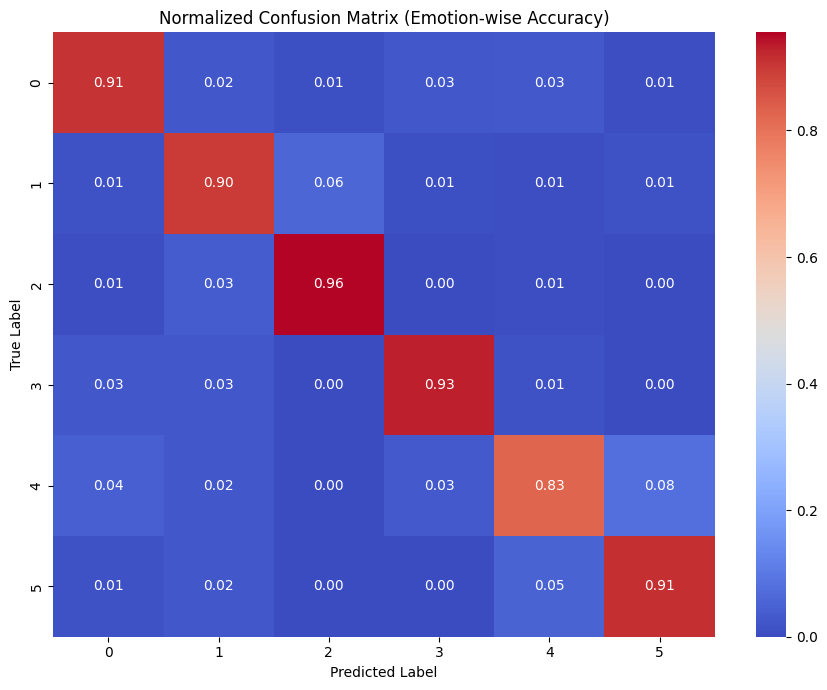

In [11]:
conf_matrix = confusion_matrix(val_df['label'], val_predictions)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9, 7))
sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)

plt.title('Normalized Confusion Matrix (Emotion-wise Accuracy)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [12]:
labels = pipeline.classes_

error_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j:
            error_pairs.append(
                (labels[i], labels[j], conf_matrix[i, j])
            )

error_pairs = sorted(error_pairs, key=lambda x: x[2], reverse=True)[:5]

print("Top Emotion Confusions:")
for true, pred, count in error_pairs:
    print(f"{true} → {pred}: {count}")


Top Emotion Confusions:
1 → 2: 42
4 → 5: 16
0 → 4: 15
0 → 3: 14
0 → 1: 13


## Thanks pls upvote!!!!